# Homework 1 
## Professionalism & Reproducibility
The goal of this assignment is to construct, analyze, and publish a dataset of monthly article traffic for a select set of pages from English Wikipedia from July 1, 2015 through September 30, 2024. The purpose of the assignment is to develop and follow best practices for open scientific research as exemplified by your repository.

For reproducing my analysis, make sure to run all the cells in order.


### License
Snippets of the below code were taken from a code example developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024



## Data Aquisition

In order to measure article traffic from 2015-2024, we need to collect data from the Wikimedia Analytics API. The Pageviews API call ([documentation](https://doc.wikimedia.org/generated-data-platform/aqs/analytics-api/reference/page-views.html)) provides access to desktop, mobile web, and mobile app traffic data starting from July 2015 through the previous complete month.

For this homework, we fetch details of all articles listed in the [provided CSV](https://drive.google.com/file/d/15_FiKhBgXB2Ch9c0gAGYzKjF0DBhEPlY/view) by calling the PageViews API with the article names. The fetched data is stored as JSON files with keys as the article title and values as the corresponding data retrieved from the API. 

In [1]:
# These are standard python modules
import json, time, urllib.parse
import os

# The below module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests
import pandas as pd

The code relies on some constants that help make the code a bit more readable. Some values might need to be updated to reflect correct paths/values.

In [2]:
#########
#
#    CONSTANTS
#

# Local path to the CSV File containing the wikipedia articles of interest. Update this to point to the correct path.
WIKIPEDIA_ARTICLES= '/Users/sushmavankayala/Documents/DATA_512/week1/rare-disease_cleaned.AUG.2024.csv'

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# Adding a small delay to each request to the Pageviews API, to not exceed 100 requests per second
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# Required headers for calling the Wikimedia API.
# They expect an email address for them to contact in case of issues(rate limiting, etc)
REQUEST_HEADERS = {
    'User-Agent': '<vanksu@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",   # Start date and end date as provided in 
    "end":         "2024093000"
}

# Creating templates for Mobile App and Mobile web by cloning the desktop template and updating the "access" value.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP["access"] = "mobile-app"

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB["access"] = "mobile-web"

Since the analysis requires writing to files and reading from files, I decided to create some variables and functions to maintain consistency among different steps and streamline the file access across this analysis

In [3]:
# Create filenames using start and end dates in the format YYYYMM
# These filenames will be used for dumping the acquired data, and for reading the data for analysis
start_date = "201501"
end_date = "202409"

# Filename for Desktop views
desktop_views_file = f"rare-disease_monthly_desktop_{start_date}-{end_date}.json"

# Filename for Mobile views
mobile_views_file = f"rare-disease_monthly_mobile_{start_date}-{end_date}.json"

# Filename for Cumulative views
cumulative_views_file = f"rare-disease_monthly_cumulative_{start_date}-{end_date}.json"

def create_directory(target_path):
    # Check if the directory already exists
    if not os.path.exists(target_path):
        try:
            # Attempt to create the directory
            os.makedirs(target_path)
        except Exception as e:
            print("Unable to create path" + target_path)
            print(e)

The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [4]:
#########
#
#    Procedures/Functions for Data Aquisition
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP,
                                  headers = REQUEST_HEADERS):

    """
    Makes a REST API call to the PageViews endpoint and returns the JSON response.

    Args:
        article_title (str): The title of the article to request pageviews for.
        endpoint_url (str): The URL of the API endpoint.
        endpoint_params (str): The parameters for the API request.
        request_template (dict): The template for the request parameters.
        headers (dict): The headers for the API request.

    Returns:
        dict or None: The JSON response from the API call, or None if an error occurs.
    """
    
    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


def write_to_file(json_data, filename, mode = "a+"):
    """
    Writes data to a specified file in JSON format.

    Args:
        json_data (any): The data to be written to the file. 
        filename (str): The path to the file where the data will be written.
        mode (str, optional): The file mode in which to open the file. 
                              Defaults to "a+" (append and read). Other common modes include:
                              - "w": write (overwrites existing content)
                              - "r": read (file must exist)
    
    Returns:
        None: This function does not return a value.
    """
    try:
        with open(filename, mode) as f:
            json.dump(json_data, f, ensure_ascii=False)
    except Exception as e:
        print(e)

The goal is to produce three files as follows:
* Monthly mobile access - The API separates mobile access types into two separate requests, we will need to sum these to make one count for all mobile pageviews. Store the mobile access data in a file called:
rare-disease_monthly_mobile_\<startYYYYMM>-\<endYYYYMM>.json
* Monthly desktop access - Monthly desktop page traffic is based on one single request. We should store the desktop access data in a file called:
rare-disease_monthly_desktop_\<startYYYYMM>-\<endYYYYMM>.json
* Monthly cumulative - Monthly cumulative data is the sum of all mobile, and all desktop traffic per article. We should store the monthly cumulative data in a file called:
rare-disease_monthly_cumulative_\<startYYYYMM>-\<endYYYYMM>.json
For all of the files the \<startYYYYMM> and \<endYYYYMM> represent the starting and ending year and month as integer text strings.

To understand the progress of data aquisition, print statements have been added to the below code.

Note: This step takes ~40mins to using a laptop with Apple M1 Pro chip and having 16GB RAM.

In [ ]:
# Read the list of wikipedia articles from the CSV file and create a dataframe
wiki_list = pd.read_csv(WIKIPEDIA_ARTICLES)

# Create empty dictionaries for each file to be created
desktop_views = {}
mobile_views = {}
cumulative_views = {}

for index, row in wiki_list.iterrows():

    # Fetch article title from dataframe
    article_title = row["disease"]
    print("Getting pageview data for disease:", article_title, ", index:", index)

    # Fetch data on desktop views for the article
    desktop_views_per_title = request_pageviews_per_article(article_title, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP)
    desktop_views_per_title = desktop_views_per_title["items"]
    # Convert JSON to dataframe
    desktop_views_df = pd.DataFrame(desktop_views_per_title)
    # Drop "access" column
    desktop_views_df = desktop_views_df.drop('access', axis=1)
    # Convert dataframe back to JSON Array, and add it to the desktop_views dictionary with article title as the key
    desktop_views[article_title] = json.loads(desktop_views_df.to_json(orient = "records"))
    print("Desktop views added to dictionary")

    
    # Fetching data on Mobile views for the article consists of 2 parts
    
    # Fetch data on Mobile App views for the article
    mobile_app_views_per_title = request_pageviews_per_article(article_title, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP)
    mobile_app_views_per_title = mobile_app_views_per_title["items"]
    # Convert JSON to dataframe
    mobile_app_views_df = pd.DataFrame(mobile_app_views_per_title)

    # Fetch data on Mobile Web views for the article
    mobile_web_views_per_title = request_pageviews_per_article(article_title, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB)
    mobile_web_views_per_title = mobile_web_views_per_title["items"]
    # Convert JSON to dataframe
    mobile_web_views_df = pd.DataFrame(mobile_web_views_per_title)

    # Merge the Mobile App and Mobile web based on the article name and timestamp. 
    # Except views and access, all other columns should have identical values. 
    # To avoid duplicate column creation on join, add the other fields in the join condition
    mobile_views_df = pd.merge(mobile_app_views_df, mobile_web_views_df, on=["project", "article", "granularity","timestamp", "agent"], how="outer")
    # Total mobile views is calculated by adding the app and web mobile views.
    mobile_views_df["views"] = mobile_views_df["views_x"] + mobile_views_df["views_y"]
    # Drop the access and views columns specific to mobile app and mobile web views dataframes.
    mobile_views_df = mobile_views_df.drop(['access_x','access_y', "views_x", "views_y"], axis=1)
    # Convert dataframe back to JSON Array, and add it to the mobile_views dictionary with article title as the key
    mobile_views[article_title] = json.loads(mobile_views_df.to_json(orient = "records"))
    print("Mobile views added to dictionary")

    # For calculating cumulative views of article, we need to sum each articles monthly views for desktop and mobile.
    # To facilitate this, merge the dataframes containing desktop views and mobile views based on the article name and timestamp
    # Except views, all other columns should have identical values.
    # To avoid duplicate column creation on join, add the other fields in the join condition
    cumulative_views_df = pd.merge(desktop_views_df, mobile_views_df, on=["project", "article", "granularity","timestamp", "agent"], how="outer")
    # Cumulative views is calculated by adding the desktop and mobile views.
    cumulative_views_df["views"] = cumulative_views_df["views_x"] + cumulative_views_df["views_y"]
    # Drop the views columns specific to desktop and mobile views dataframes.
    cumulative_views_df = cumulative_views_df.drop(["views_x", "views_y"], axis=1)
    # Convert dataframe back to JSON Array, and add it to the cumulative_views dictionary with article title as the key
    cumulative_views[article_title] = json.loads(cumulative_views_df.to_json(orient = "records"))
    print("Cumulative views added to dictionary")

    print("--------")
    print()


Now we have a handle on 3 dictionaries, each having information about the corresponding monthly views per article title. 
Next step is to dump these dictionaries into JSON files for easier access in future. 
The data in these JSON files will be used to run analysis on the view counts per access type.

In [ ]:
# Dump the dictionary containing views into the corresponding JSON file

# Create the target directory
target_folder = "generated_files"
create_directory(target_folder)

# Dumping Desktop views into file
write_to_file(desktop_views, filename=f"{target_folder}/{desktop_views_file}", mode="w+")

# Dumping Mobile views into file
write_to_file(mobile_views, filename=f"{target_folder}/{mobile_views_file}", mode="w+")

# Dumping Cumulative views into file
write_to_file(cumulative_views, filename=f"{target_folder}/{cumulative_views_file}", mode="w+")

# Data Analysis

We want to do a basic visual analysis of the data by producing 3 different graphs.

* Maximum Average and Minimum Average - Contains time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series. 
* Top 10 Peak Page Views - Contains time series for the top 10 article pages by largest (peak) page views over the entire time series by access type. 
* Fewest Months of Data - Should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

### Data Processing

Considering the data required to create these graphs, I have decided to write a helper function that helps to aggregate the data corresonding to a particular article and stores information like max views, min views, average views, and count of months for which the data is available.

In [5]:
#########
#
#    Procedures/Functions for Data Processing
#

def aggregate_article_data(filename):
    """
    Aggregates view data from a JSON file containing data for multiple articles.

    Args:
        filename: The path to the JSON file containing article view data.

    Returns:
        list: A list of dictionaries, each containing aggregated view statistics 
              for an article, including counts, maximum, minimum, and average views.
    """

    # Initialize an empty list to hold aggregated data for each article
    aggregated_counts = []

    # Open the specified JSON file for reading
    with open(filename) as json_file:
        views = json.load(json_file)
        # Iterate over each article's title and its associated view data
        for article_title, view_data in views.items():
            
            # Convert the view data for the article into a pandas DataFrame
            views_df = pd.DataFrame(view_data)
            max_views = views_df['views'].max()
            min_views= views_df['views'].min()

            # Prepare a dictionary to hold aggregated statistics for the article
            aggregate = {
                "article_title": article_title,  # Title of the article
                "count": views_df.shape[0],      # Total number of data entries for the article
                "max_views": max_views,           # Maximum views recorded
                "max_month": views_df[views_df['views'] == max_views].iloc[0]['timestamp'],  # Timestamp of max views
                "min_views": min_views,           # Minimum views recorded
                "min_month": views_df[views_df['views'] == min_views].iloc[0]['timestamp'],  # Timestamp of min views
                "avg_views": views_df['views'].mean(),  # Average views computed
                "data": view_data                 # Raw view data for the article
            }

            # Append the aggregated data for the current article to the list
            aggregated_counts.append(aggregate)

    return aggregated_counts

In [6]:
# Aggegate data from the JSON files created by the end of Data Aquisition steps
target_folder = "generated_files"
# Aggregate JSON file containing desktop views data
desktop_aggregate = aggregate_article_data(f"{target_folder}/{desktop_views_file}")
desktop_aggregate_df = pd.DataFrame(desktop_aggregate)

# Aggregate JSON file containing mobile views data
mobile_aggregate = aggregate_article_data(f"{target_folder}/{mobile_views_file}")
mobile_aggregate_df = pd.DataFrame(mobile_aggregate)

### Data Visualization

Now that we have the aggregated data (both mobile and desktop), we proceed with plotting the above mentioned graphs.

For a clear segregation between lines representing Desktop views and Mobile views, I've decided to use solid lines for desktop, and dashed lines for mobile.

In [7]:
# Import the package for drawing plots.
import matplotlib.pyplot as plt

# Create a directory for saving the generated plots
target_folder_plots = "generated_plots"
create_directory(target_folder_plots)

#### Graph 1: Maximum Average and Minimum Average
This graph contains time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series. The graph has four lines (max desktop, min desktop, max mobile, min mobile)

Helper functions are created to find the articles with max average views and min average views.

In [8]:
def article_with_max_average(aggregated_df):
    """
    Retrieves the article with the highest average views from the aggregated DataFrame.

    Args:
        aggregated_df (pd.DataFrame): A DataFrame containing aggregated statistics 
                                       for articles, including average views.

    Returns:
        pd.Series: A Series representing the row of the article with the maximum 
                    average views.
    """
    # Use idxmax to find the index of the article with the highest average views
    # and return the corresponding row from the DataFrame
    return aggregated_df.iloc[aggregated_df["avg_views"].idxmax()]

def article_with_min_average(aggregated_df):
    """
    Retrieves the article with the least average views from the aggregated DataFrame.

    Args:
        aggregated_df (pd.DataFrame): A DataFrame containing aggregated statistics 
                                       for articles, including average views.

    Returns:
        pd.Series: A Series representing the row of the article with the minimum 
                    average views.
    """
    # Use idxmin to find the index of the article with the highest average views
    # and return the corresponding row from the DataFrame
    return aggregated_df.iloc[aggregated_df["avg_views"].idxmin()]

In [9]:
# Finding details of articles with highest and least avg views.

# Initialize an empty list to store time series data for articles
time_series_data = []

# Find article for each condition given. For each article found, 
# Convert the article's view data into a DataFrame
# Convert the 'timestamp' column to datetime format for easier time series manipulation

# Retrieve the article with the highest average views from the desktop aggregated DataFrame
article_max_d = article_with_max_average(desktop_aggregate_df)
print("Article with highest average views(desktop):", article_max_d["article_title"])
article_max_d_df = pd.DataFrame(article_max_d["data"])
article_max_d_df['date'] = pd.to_datetime(article_max_d_df['timestamp'], format='%Y%m%d%H')

# Retrieve the article with the lowest average views from the desktop aggregated DataFrame
article_min_d = article_with_min_average(desktop_aggregate_df)
print("Article with lowest average views(desktop):", article_min_d["article_title"])
article_min_d_df = pd.DataFrame(article_min_d["data"])
article_min_d_df['date'] = pd.to_datetime(article_min_d_df['timestamp'], format='%Y%m%d%H')

# Retrieve the article with the highest average views from the mobile aggregated DataFrame
article_max_m = article_with_max_average(mobile_aggregate_df)
print("Article with Highest average views(mobile):", article_max_m["article_title"])
article_max_m_df = pd.DataFrame(article_max_m["data"])
article_max_m_df['date'] = pd.to_datetime(article_max_m_df['timestamp'], format='%Y%m%d%H')

# Retrieve the article with the lowest average views from the mobile aggregated DataFrame
article_min_m = article_with_min_average(mobile_aggregate_df)
print("Article with least average views(mobile):", article_min_m["article_title"])
article_min_m_df = pd.DataFrame(article_min_m["data"])
article_min_m_df['date'] = pd.to_datetime(article_min_m_df['timestamp'], format='%Y%m%d%H')


Article with highest average views(desktop): Black Death
Article with lowest average views(desktop): Filippi Syndrome
Article with Highest average views(mobile): Black Death
Article with least average views(mobile): Filippi Syndrome


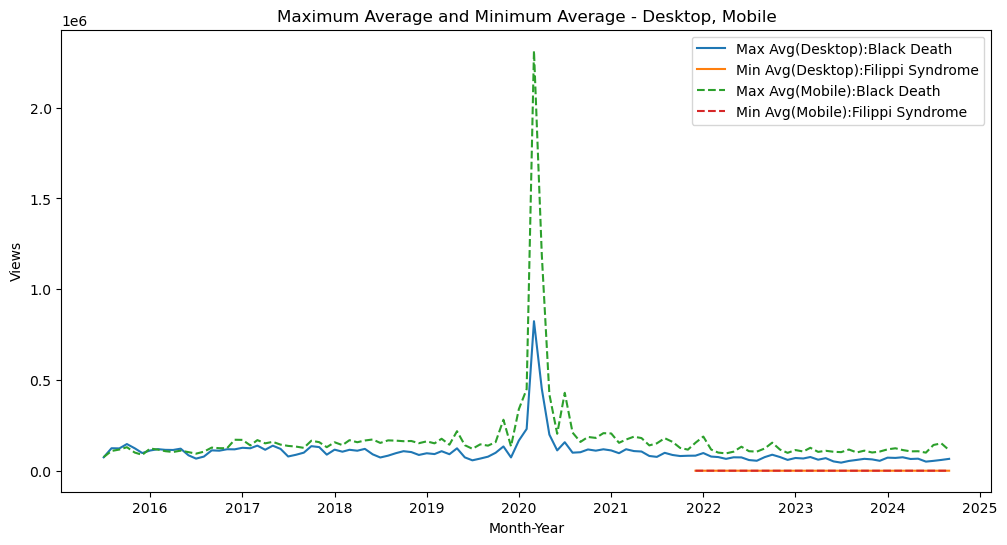

In [10]:
# Set plot size
plt.figure(figsize=(12,6))

# Plot a seperate line for each case
plt.plot(article_max_d_df["date"], article_max_d_df["views"], label="Max Avg(Desktop):" + article_max_d["article_title"] )
plt.plot(article_min_d_df["date"], article_min_d_df["views"], label="Min Avg(Desktop):" + article_min_d["article_title"])
plt.plot(article_max_m_df["date"], article_max_m_df["views"], label="Max Avg(Mobile):" + article_max_m["article_title"], linestyle="dashed")
plt.plot(article_min_m_df["date"], article_min_m_df["views"], label="Min Avg(Mobile):" + article_min_m["article_title"], linestyle="dashed")

# Set the X-axis and Y axis labels, along with the title of the plot.
plt.xlabel('Month-Year')
plt.ylabel('Views')
plt.title('Maximum Average and Minimum Average - Desktop, Mobile')

# Add legend
plt.legend()

# Save plot as png
plt.savefig("generated_plots/max_avg_min_avg.png", bbox_inches='tight') 

# Show the plot
plt.show()

##### Analysis
From the above graph, we see that the article on disease "Black Death" has the highest average page requests, both in deskop and mobile. We see that the number of views peaked during the earlier months of the year 2020. We also see that in the month with highest views, the number of times the article was viewed on mobile is more than twice the number of views via desktop.

The article on disease "Filippi Syndrome" has the least average page requests, both in desktop and mobile. Wee see that the data on views is available only from the later months of year 2021.

#### Graph 2: Top 10 Peak Page Views
This graph contains time series for the top 10 article pages by largest (peak) page views over the entire time series by access type. To find the top 10, first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. The graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

Helper function is created to find the articles with max average views and min average views.

In [11]:
def top_10_peaks(aggregated_df):
    """
    Retrieves the top 10 articles with the largest max views from the aggregated DataFrame.

    Args:
        aggregated_df (pd.DataFrame): A DataFrame containing aggregated statistics 
                                       for articles, including average views.

    Returns:
        pd.dataframe: A dataframe containing 10 rows having maximum monthly views, where each row is an article.
    """
    # sort the data frame based on max_views in decending order.
    # The top 10 rows of the sorted dataframe represent the articles with highest peaks.
    top_10 =  aggregated_df.sort_values("max_views", ascending=False).head(10)
    return top_10

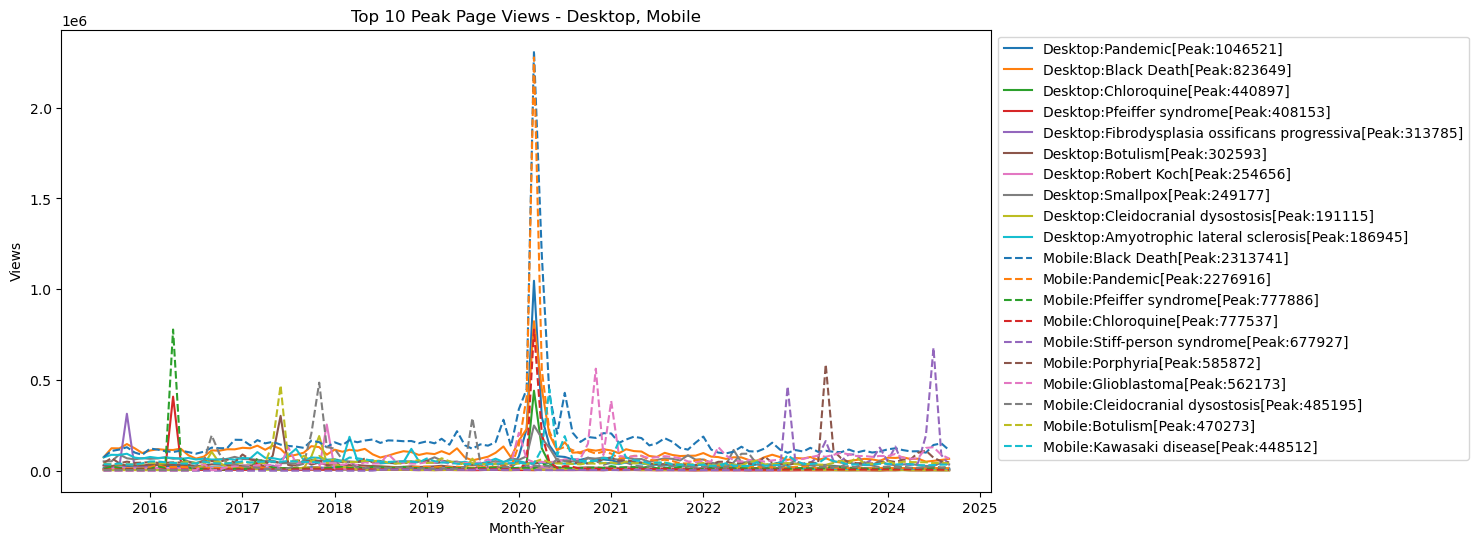

In [12]:
# Set plot size
plt.figure(figsize=(12,6))

# Process and plot top 10 peaks for desktop data
top_10_peaks_desktop_df = top_10_peaks(desktop_aggregate_df)
for index, row in top_10_peaks_desktop_df.iterrows():
    # Create temporary dataframe for each peak
    temp_df = pd.DataFrame(row["data"])
    # Convert timestamp to datetime
    temp_df['date'] = pd.to_datetime(temp_df['timestamp'], format='%Y%m%d%H')
    # Plot desktop data
    plt.plot(temp_df["date"], temp_df["views"], label="Desktop:" + row["article_title"] + "[Peak:"+str(row["max_views"]) + "]")

# Process and plot top 10 peaks for mobile data
top_10_peaks_mobile_df = top_10_peaks(mobile_aggregate_df)
for index, row in top_10_peaks_mobile_df.iterrows():
    # Create temporary dataframe for each peak
    temp_df = pd.DataFrame(row["data"])
    # Convert timestamp to datetime
    temp_df['date'] = pd.to_datetime(temp_df['timestamp'], format='%Y%m%d%H')
    # Plot mobile data with dashed lines
    plt.plot(temp_df["date"], temp_df["views"], label="Mobile:" + row["article_title"]+ "[Peak:"+str(row["max_views"]) + "]", linestyle='dashed')

# Set the X-axis and Y axis labels, along with the title of the plot.
plt.xlabel('Month-Year')
plt.ylabel('Views')
plt.title('Top 10 Peak Page Views - Desktop, Mobile')

# Add legend to distinguish between different lines
plt.legend(bbox_to_anchor=(1, 1))

# Save plot as png
plt.savefig("generated_plots/top_10_peak_page_views.png", bbox_inches='tight') 

# Display the plot
plt.show()

##### Analysis
From the above graph, we see that majority of the evident peaks correspond to article views on mobile(represented by dashed lines). The legend beside the graph provides details about the article names, the access type (Desktop / Mobile) and the number of times it was viewed in the articles "most popular" month.

We see that the articles titled "Pandemic" and "Black Death" are the top 2 in both desktop and mobile. While "Pandemic" has the largest desktop views, "Black Death" has the highest number of mobile views in a given month. 

#### Graph 3: Fewest Months of Data 
This graph shows pages that have the fewest months of available data. It shows the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

A helper function is created to find the articles with max average views and min average views.

In [13]:
def fewest_months(aggregated_df):
    """
    Retrieves 10 articles with the fewest months of data from the aggregated DataFrame.

    Args:
        aggregated_df (pd.DataFrame): A DataFrame containing aggregated statistics 
                                       for articles, including average views.

    Returns:
        pd.dataframe: A dataframe containing 10 rows having fewest months of data, where each row is an article.
    """
    fewest_data = aggregated_df.sort_values("count").head(10)
    return fewest_data

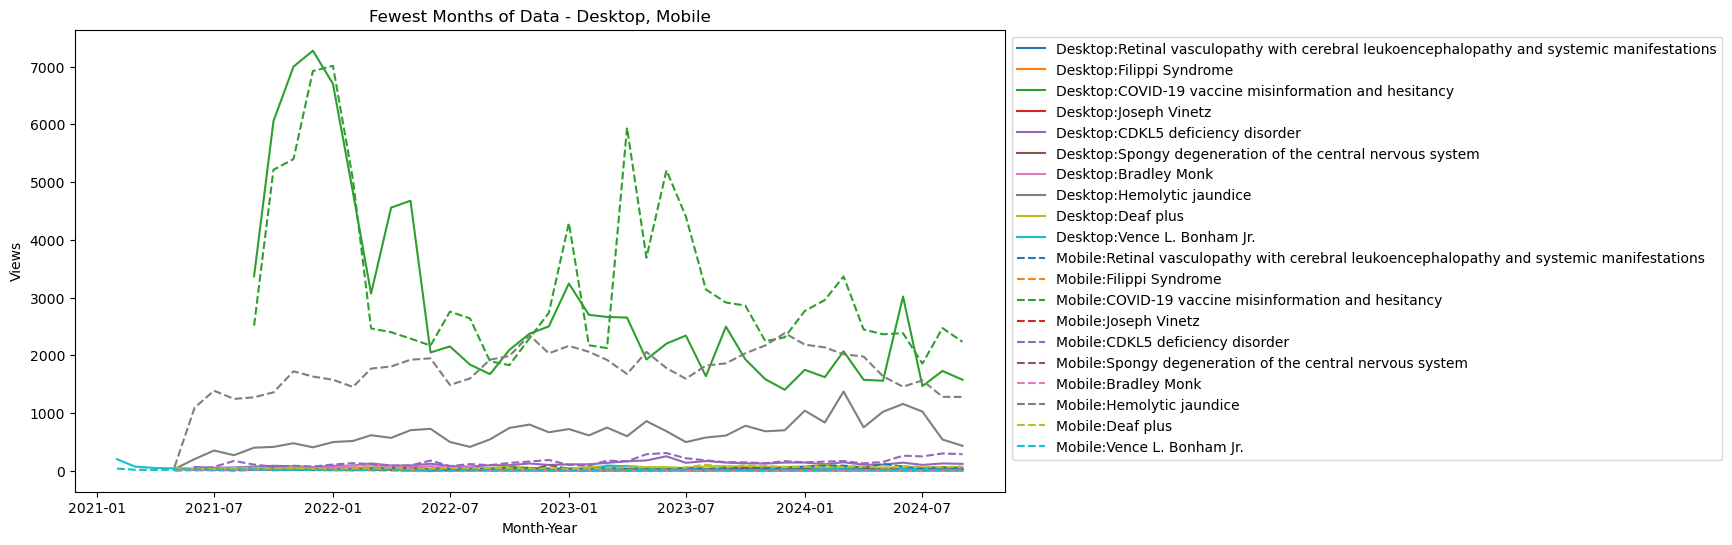

In [14]:
# Set plot size
plt.figure(figsize=(12,6))

# Process and plot 10 articles with fewest data for desktop data
fewest_months_desktop_df = fewest_months(desktop_aggregate_df)
for index, row in fewest_months_desktop_df.iterrows():
    # Create temporary dataframe for each article
    temp_df = pd.DataFrame(row["data"])
    # Convert timestamp to datetime
    temp_df['date'] = pd.to_datetime(temp_df['timestamp'], format='%Y%m%d%H')
    # Plot desktop data
    plt.plot(temp_df["date"], temp_df["views"], label="Desktop:" + row["article_title"] )

# Process and plot 10 articles with fewest data for mobile data
fewest_months_mobile_df = fewest_months(mobile_aggregate_df)
for index, row in fewest_months_mobile_df.iterrows():
    # Create temporary dataframe for each article
    temp_df = pd.DataFrame(row["data"])
    # Convert timestamp to datetime
    temp_df['date'] = pd.to_datetime(temp_df['timestamp'], format='%Y%m%d%H')
    # Plot mobile data with dashed lines
    plt.plot(temp_df["date"], temp_df["views"], label="Mobile:" + row["article_title"], linestyle='dashed' )

# Set the X-axis and Y axis labels, along with the title of the plot.
plt.xlabel('Month-Year')
plt.ylabel('Views')
plt.title('Fewest Months of Data - Desktop, Mobile')

# Add legend to distinguish between different lines
plt.legend(bbox_to_anchor=(1, 1))

# Save plot as png
plt.savefig("generated_plots/fewest_months_of_data.png", bbox_inches='tight') 

# Display the plot
plt.show()

##### Analysis
From the above graph, we see that the articles having data for the least amount of months are having a fairly low number of views; with an exception of articles on "COVID-19 vaccine misinformation and hesitancy", and "Hemolytic jaundice". Even then, the view counts in this graph are fairly small in comparision to the previous graphs where views are in the order of 10^6.

Interestingly, we see that the view trend for the article on COVID-19 vaccine misinformation is fairly distinct between the access types desktop and mobile; especially in the earlier months of 2023. We might need more domain knowledge to find out if there is a specific reason for this behaviour.